In [1]:
from lbmpy.session import *

# Tutorial 03: Defining LB methods in *lbmpy*


## A) General Form

The lattice Boltzmann equation in its most general form is:

$$f_q(\mathbf{x} + \mathbf{c}_q \delta t, t+\delta t) = K\left( f_q(\mathbf{x}, t) \right)$$

with a discrete velocity set $\mathbf{c}_q$ (stencil) and a generic collision operator $K$.

So a lattice Boltzmann method can be fully defined by picking a stencil and a collision operator. 
The collision operator $K$ has the following structure:
- Transformation of particle distribution function $f$ into collision space. This transformation has to be invertible and may be nonlinear.
- The collision operation is an convex combination of the pdf representation in collision space $c$ and some equilibrium vector $c^{(eq)}$. This equilibrium can also be defined in physical space, then $c^{(eq)} = C( f^{(eq)} ) $. The convex combination is done elementwise using a diagonal matrix $S$ where the diagonal entries are the relaxation rates.
- After collision, the collided state $c'$ is transformed back into physical space

![](../img/collision.svg)


The full collision operator is:

$$K(f) = C^{-1}\left( (I-S)C(f) + SC(f^{(eq}) \right)$$

or

$$K(f) = C^{-1}\left( C(f) - S (C(f) - C(f^{(eq})) \right)$$

## B) Moment-based relaxation

The most commonly used LBM collision operator is the multi relaxation time (MRT) collision.
In MRT methods the collision space is spanned by moments of the distribution function. This is a very natural approach, since the pdf moments are the quantities that go into the Chapman Enskog analysis that is used to show that LB methods can solve the Navier Stokes equations. Also the lower order moments correspond to the macroscopic quantities of interest (density/pressure, velocity, shear rates, heat flux). Furthermore the transformation to collision space is linear in this case, simplifying the collision equations:

$$K(f) = C^{-1}\left( C(f) - S (C(f) - C(f^{(eq})) \right)$$

$$K(f) = f - \underbrace{ C^{-1}SC}_{A}(f - f^{(eq)})$$

in *lbmpy* the following formulation is used, since it is more natural to define the equilibrium in moment-space instead of physical space:

$$K(f) = f -  C^{-1}S(Cf - c^{(eq)})$$

### Use a pre-defined method

Lets create a moment-based method in *lbmpy* and see how the moment transformation $C$ and the relaxation rates that comprise the diagonal matrix $S$ can be defined. We start with a function that creates a basic MRT model.
Don't use this for real simulations, there orthogonalized MRT methods should be used, as discussed in the next section.

In [2]:
from lbmpy.creationfunctions import create_lb_method
lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.MRT_RAW, zero_centered=False)

method = create_lb_method(lbm_config=lbm_config)
# check also method='srt', 'trt', 'mrt'
method

The first column labeled "Moment" defines the collision space and thus the transformation matrix $C$.
The remaining columns specify the equilibrium vector in moment space $c^{(eq)}$ and the corresponding relaxation rate.

Each row of the "Moment" column defines one row of $C$. In the next cells this matrix and the discrete velocity set (stencil) of our method are shown. Check for example the second last row of the table $x^2 y$: In the corresponding second last row of the moment matrix $C$ where each column stands for a lattice velocity (for ordering visualized stencil below) and each entry is the expression $x^2 y$ where $x$ and $y$ are the components of the lattice velocity.

In general the transformation matrix $C_{iq}$ is defined as;

$$c_i = C_{iq} f_q = \sum_q  m_i(\mathbf{c}_q)$$

where $m_i(\mathbf{c}_q)$ is the $i$'th moment polynomial where $x$ and $y$ are substituted with the components of the $q$'th lattice velocity

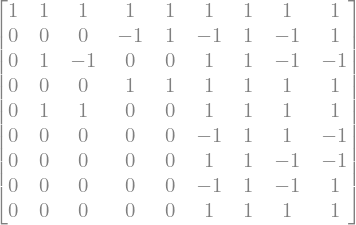

In [3]:
# Transformation matrix C
method.moment_matrix

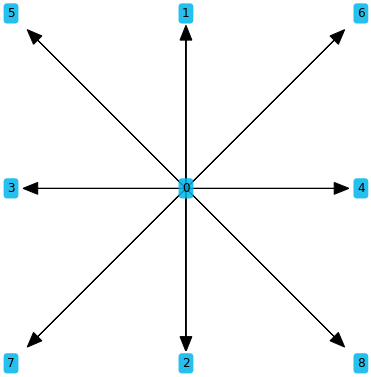

In [4]:
method.stencil.plot()

In [5]:
method.stencil

Nr.,Direction Name,Direction
$0$,$\mathtt{\text{C}}$,"$\left( 0, \ 0\right)$"
$1$,$\mathtt{\text{N}}$,"$\left( 0, \ 1\right)$"
$2$,$\mathtt{\text{S}}$,"$\left( 0, \ -1\right)$"
$3$,$\mathtt{\text{W}}$,"$\left( -1, \ 0\right)$"
$4$,$\mathtt{\text{E}}$,"$\left( 1, \ 0\right)$"
$5$,$\mathtt{\text{NW}}$,"$\left( -1, \ 1\right)$"
$6$,$\mathtt{\text{NE}}$,"$\left( 1, \ 1\right)$"
$7$,$\mathtt{\text{SW}}$,"$\left( -1, \ -1\right)$"
$8$,$\mathtt{\text{SE}}$,"$\left( 1, \ -1\right)$"


### Orthogonal MRTs

For a real MRT method, the moments should be orthogonalized.
One can either orthogonalize using the standard scalar product or a scalar product that is weighted with the lattice weights. If unsure, use the weighted version.

The next cell shows how to get both orthogonalized MRT versions in lbmpy.


In [6]:
rr = [sp.Symbol('omega_shear'), sp.Symbol('omega_bulk'), sp.Symbol('omega_3'), sp.Symbol('omega_4')]

lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.MRT, weighted=True,
                       relaxation_rates=rr, zero_centered=False)
weighted_ortho_mrt = create_lb_method(lbm_config=lbm_config)
weighted_ortho_mrt

In [7]:
lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.MRT, weighted=False,
                       relaxation_rates=rr, zero_centered=False)
ortho_mrt = create_lb_method(lbm_config=lbm_config)
ortho_mrt

One can check if a method is orthogonalized:

In [8]:
ortho_mrt.is_orthogonal, weighted_ortho_mrt.is_weighted_orthogonal

(True, True)

Note here how the relaxation rate for each moment is set. By default, a single relaxation rate per moment group is assigned. With a moment group, we mean here moment polynomials of the same order. However, the second-order moments are split between the shear and bulk moments (defining the shear and bulk viscosity). Thus the first two relaxation rates in the `rr`-list are used for these. 

If only a single relaxation rate would be defined, it is applied to the shear moments, and all other higher-order moments are set to one. This means the PDFs are directly fixed to the equilibrium in the collision process. Furthermore, the relaxation rate for conserved moments can be chosen freely as they are conserved in the collision. Thus by default, we set it to zero.

It is also possible to define an individual relaxation rate per moment. In this case, `Q` relaxation rates need to be defined, where `Q` is the number of moments.

### Central moment lattice Boltzmann methods


Another popular method is the cascaded lattice Boltzmann method. The cascaded LBM increases the numerical stability by shifting the collision step to the central moment space. Thus it is applied in the non-moving frame and achieves a better Galilean invariance. Typically the central moment collision operator is derived for compressible LB methods, and a higher-order equilibrium is used. Although incompressible LB methods with a second-order equilibrium can be derived with lbmpy, it violates the Galilean invariance and thus reduces the advantages of the method.

In [9]:
lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.CENTRAL_MOMENT, equilibrium_order=4,
                       compressible=True, relaxation_rates=rr)

central_moment_method = create_lb_method(lbm_config)
central_moment_method

The shift to the central moment space is done by applying a so-called shift matrix. Usually, this introduces a high numerical overhead. This problem is solved with lbmpy because each transformation stage can be specifically optimised individually. Therefore, it is possible to derive a CLBM with only a little numerical overhead.

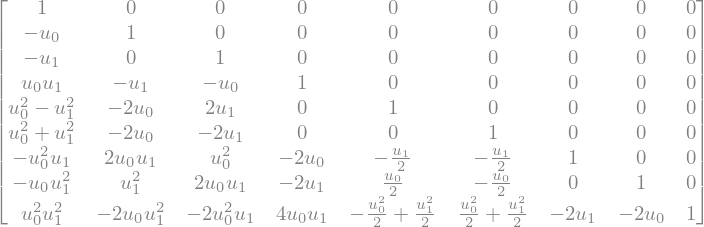

In [10]:
central_moment_method.shift_matrix

### Define custom MRT method

To choose custom values for the left moment column one can pass a nested list of moments.
Moments that should be relaxed with the same paramter are grouped together.

*lbmpy* also comes with a few templates for this list taken from literature:

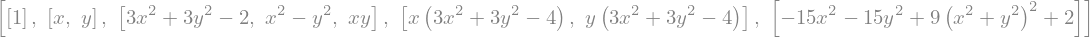

In [11]:
from lbmpy.methods import mrt_orthogonal_modes_literature
from lbmpy.moments import MOMENT_SYMBOLS

x, y, z = MOMENT_SYMBOLS

moments = mrt_orthogonal_modes_literature(LBStencil(Stencil.D2Q9), is_weighted=True)
moments

This nested moment list can be passed to `create_lb_method`:

In [12]:
method = create_lb_method(LBMConfig(stencil=Stencil.D2Q9, method=Method.MRT, nested_moments=moments,
                           relaxation_rates=rr, continuous_equilibrium=False, zero_centered=False))
method

Here, by setting `continuous_equilibrium=False`, the values at equilibrium of these moments are computed directly from the discrete Maxwellian distribution, and truncated at the second order in velocity. Here, customization options include changing the desired order in velocity, or to compute the moments of the continuous Maxwellian instead (this only makes a difference for truncated stencils, like D3Q19).

Our MRT method can be directly passed into one of the scenarios. We can for example set up a channel flow with it. Since we used symbols as relaxation rates, we have to pass them in as `kernel_params`.

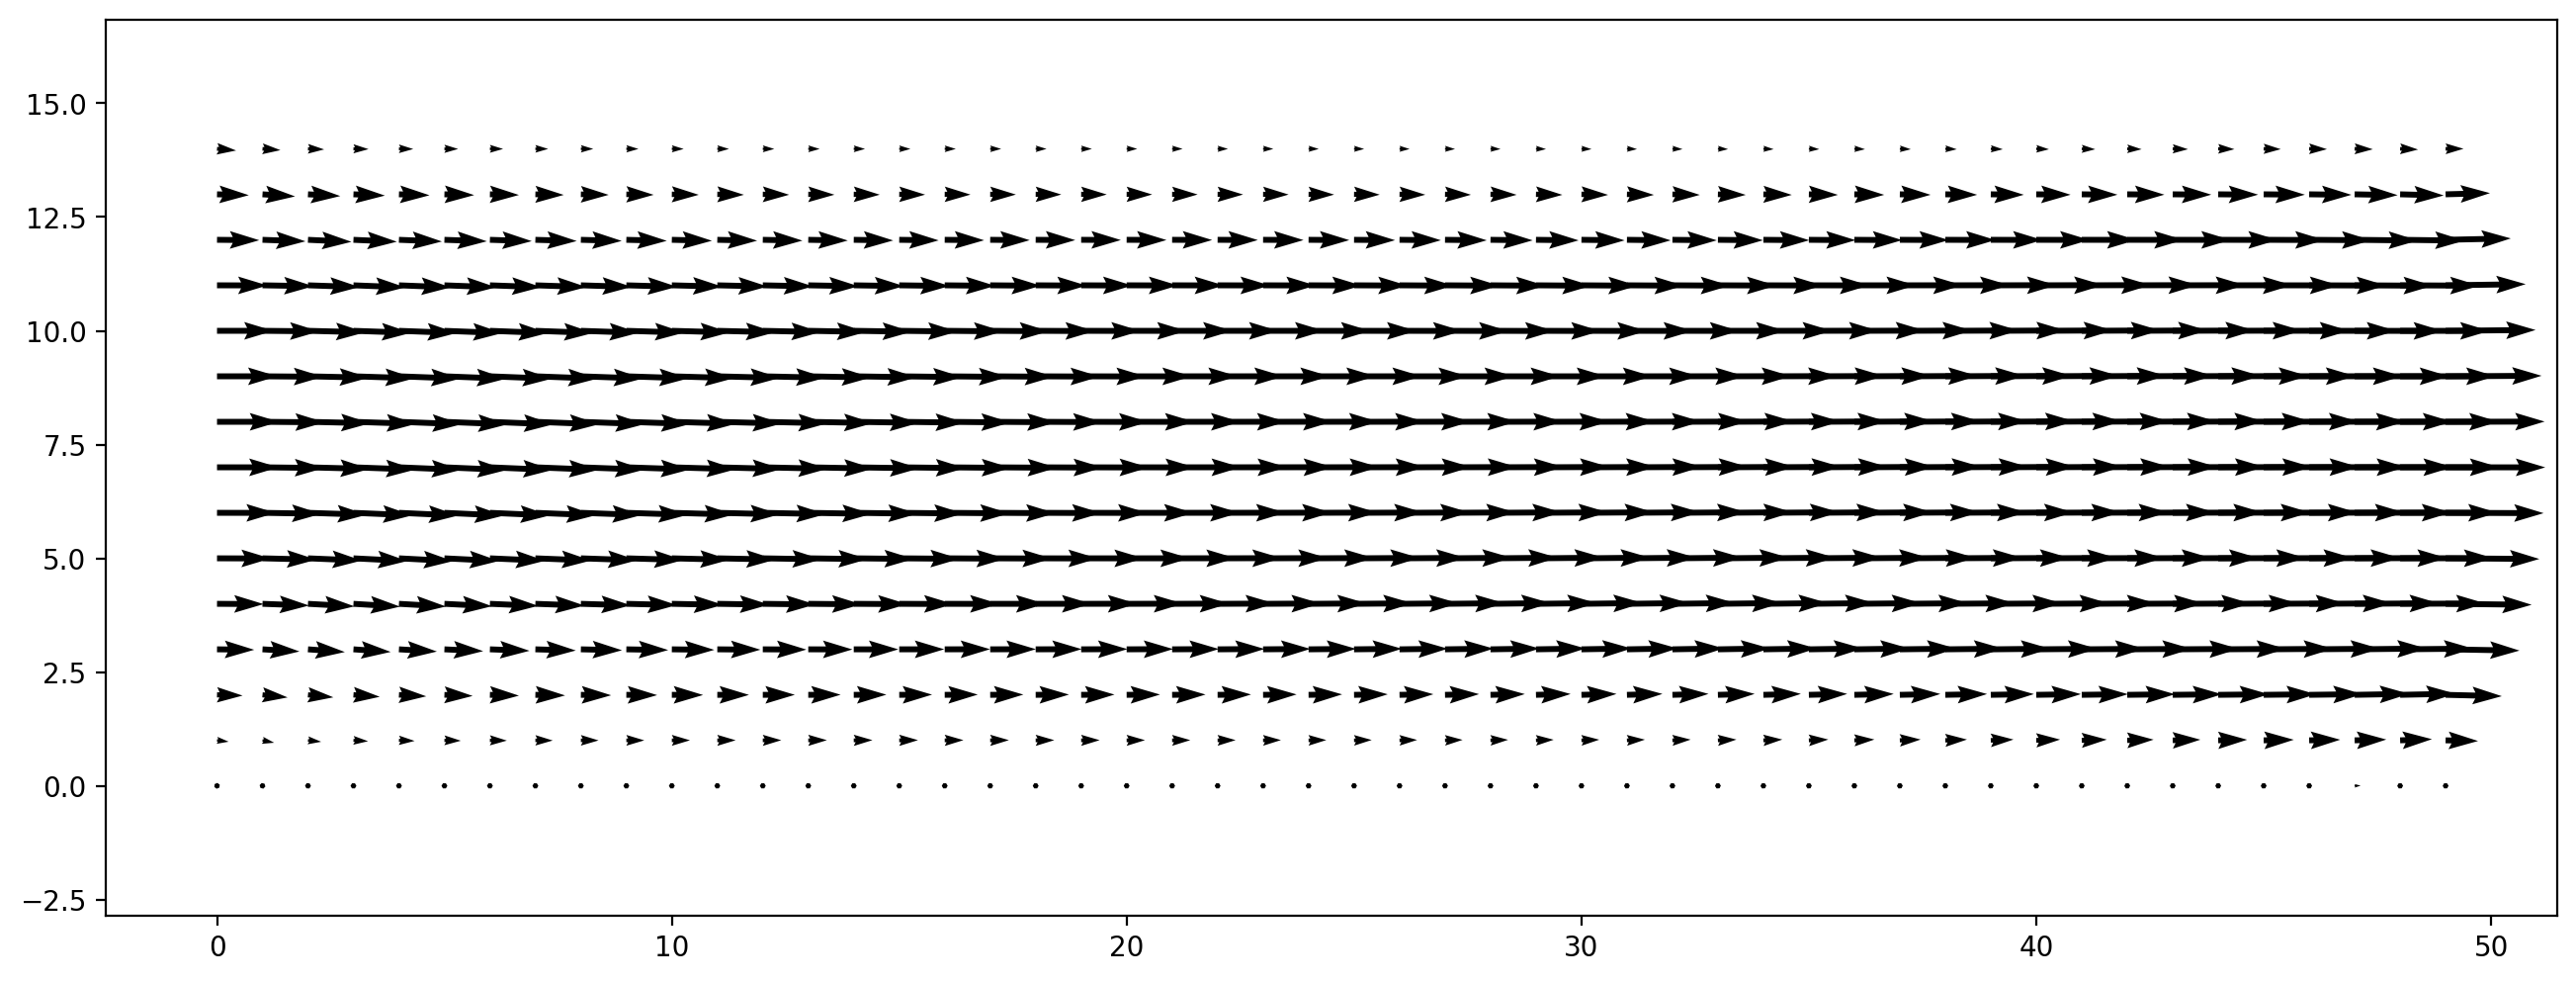

In [13]:
ch = create_channel(domain_size=(100, 30), lb_method=method, u_max=0.05,
                    kernel_params={'omega_bulk': 1.8, 'omega_shear': 1.4, 'omega_3': 1.0, 'omega_4': 1.0})
ch.run(500)
plt.figure(dpi=200)
plt.vector_field(ch.velocity[:, :]);

#### Bonus: Automatic analysis
For moment-based methods, *lbmpy* also offers an automatic Chapman Enskog analysis that can find the relation between viscosity and relaxation rate(s):

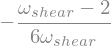

In [14]:
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis
analysis = ChapmanEnskogAnalysis(method)
analysis.get_dynamic_viscosity()

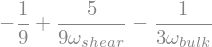

In [15]:
analysis.get_bulk_viscosity()